In [1]:
import torch
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image
from torch import nn
from torchvision import transforms, models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0'
random_seed = 42
torch.manual_seed(random_seed)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path1 = self.data_frame.iloc[idx, 0]
        img_path2 = self.data_frame.iloc[idx, 1]
        label = self.data_frame.iloc[idx, 2]

        image1 = Image.open(img_path1).convert('RGB')
        image2 = Image.open(img_path2).convert('RGB')

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return image1, image2, label

In [4]:
transform1 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [5]:
train_dataset = CustomDataset('./train.csv', transform = transform1)
valid_dataset = CustomDataset('./valid.csv', transform = transform1)
test_dataset = CustomDataset('./test.csv', transform = transform1)

In [6]:
class Siamese_Net1(nn.Module):
    def __init__(self, rnet):
        super().__init__()

        self.conv_net = nn.Sequential(*list(rnet.children())[:-2])
        self.fc1 = nn.Linear(512 * 4, 512 * 2)
        self.fc2 = nn.Linear(512 * 2, 512)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.3)

    def forward(self, X):
        x, y = torch.split(X, 3, dim=1)
        x1 = self.drop(self.conv_net(x))
        x1 = torch.flatten(x1, start_dim=1)
        x2 = self.drop(self.relu(self.fc1(x1)))
        x3 = self.fc2(x2)

        y1 = self.drop(self.conv_net(y))
        y1 = torch.flatten(y1, start_dim=1)
        y2 = self.drop(self.relu(self.fc1(y1)))
        y3 = self.fc2(y2)

        return x3, y3

In [7]:
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=1, keepdim=True))

def contrastive_loss(lables, y1, y2, margin = 10.0):
    dist = euclidean_distance(y1, y2)
    return torch.mean(lables * torch.square(dist) + (1 - lables) * torch.square(torch.clamp(margin - dist, min=0)))

In [8]:
def validate(model, validation_loader, loss_fn):
  validation_loss = 0.0
  model.eval()
  with torch.no_grad(): 
    for j, (img1_batch, img2_batch, labels) in enumerate(validation_loader):
      img1_batch = img1_batch.to(device)
      img2_batch = img2_batch.to(device)
      labels = labels.to(device)
      X = torch.cat([img1_batch, img2_batch], dim=1)

      y1, y2 = model(X)
      loss = loss_fn(labels, y1, y2)
      
      validation_loss += loss.item()

  return validation_loss

In [9]:
def train(model, optimizer, loss_fn, train_loader, validation_loader, learning_rate, num_epochs):
  history = {'train_loss' : [], 'val_loss' : []}
  optimizer = optimizer(model.parameters(), learning_rate)

  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for i, (img1_batch, img2_batch, labels) in enumerate(train_loader):
      img1_batch = img1_batch.to(device)
      img2_batch = img2_batch.to(device)
      labels = labels.to(device)
      X = torch.cat([img1_batch, img2_batch], dim=1)

      y1, y2 = model(X)
      loss = loss_fn(labels, y1, y2)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
    
    # Validation Step
    validation_loss = validate(model, validation_loader, loss_fn)

    if epoch % 2 == 0:
      print("Epoch", epoch+1, "-\tTraining Loss :", train_loss, "\tValidation Loss :", validation_loss)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(validation_loss)

  return history

In [10]:
rnet = models.resnet18(weights='DEFAULT')
model1 = Siamese_Net1(rnet).to(device)
summary(model1, (6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
def compute_best_thr(distances, labels):
    max_acc, best_thresh = 0.0, -1
    corr_tpr, corr_tnr = 0.0, 0.0
    step = 0.001
    
    dmax = np.max(distances)
    dmin = np.min(distances)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)


    for d in np.arange(dmin, dmax+step, step):
        idx1 = distances.ravel() <= d
        idx2 = distances.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
            corr_tpr, corr_tnr = tpr, tnr
   
    print("True Positive Rate =", corr_tpr)
    print("True Negative Rate =", corr_tnr)
    return max_acc, best_thresh

In [13]:
def get_distances(model, validation_loader):
    distances = []
    labels = []
    model.eval()
    with torch.no_grad():
        for j, (img1_batch, img2_batch, labs) in enumerate(validation_loader):
            img1_batch = img1_batch.to(device)
            img2_batch = img2_batch.to(device)
            X = torch.cat([img1_batch, img2_batch], dim=1)

            y1, y2 = model(X)
            distances.append(euclidean_distance(y1, y2).squeeze())
            labels.append(labs)

    d = torch.cat(distances)
    l = torch.cat(labels)

    return d.cpu().detach().numpy(), l.cpu().detach().numpy()

In [14]:
distances, labels = get_distances(model1, validation_loader)
valid_acc, threshold = compute_best_thr(distances, labels)
print(valid_acc, threshold)

True Positive Rate = 0.466796875
True Negative Rate = 0.9140625
0.6904296875 7.189


In [15]:
epochs = 30
learning_rate = 0.0001

optimizer = torch.optim.RMSprop
loss_fn = contrastive_loss

rnet = models.resnet18(weights='DEFAULT')
model1 = Siamese_Net1(rnet).to(device)
history1 = train(model1, optimizer, loss_fn, train_loader, validation_loader, learning_rate=learning_rate, num_epochs=epochs)

distances, labels = get_distances(model1, validation_loader)
valid_acc, threshold1 = compute_best_thr(distances, labels)
print("Valid Accuracy =", valid_acc, "Best Threshold =", threshold1)

  3%|▎         | 1/30 [00:16<07:58, 16.49s/it]

Epoch 1 -	Training Loss : 2923.8899421691895 	Validation Loss : 276.4757270812988


 10%|█         | 3/30 [00:49<07:25, 16.52s/it]

Epoch 3 -	Training Loss : 2826.8960514068604 	Validation Loss : 264.6439094543457


 17%|█▋        | 5/30 [01:21<06:47, 16.31s/it]

Epoch 5 -	Training Loss : 2796.5914611816406 	Validation Loss : 269.90638542175293


 23%|██▎       | 7/30 [01:54<06:14, 16.28s/it]

Epoch 7 -	Training Loss : 2776.702434539795 	Validation Loss : 280.2397766113281


 30%|███       | 9/30 [02:27<05:44, 16.43s/it]

Epoch 9 -	Training Loss : 2764.7208728790283 	Validation Loss : 288.8313751220703


 37%|███▋      | 11/30 [02:59<05:10, 16.32s/it]

Epoch 11 -	Training Loss : 2757.9229373931885 	Validation Loss : 295.8243293762207


 43%|████▎     | 13/30 [03:33<04:40, 16.51s/it]

Epoch 13 -	Training Loss : 2741.01033782959 	Validation Loss : 304.2141799926758


 50%|█████     | 15/30 [04:06<04:08, 16.54s/it]

Epoch 15 -	Training Loss : 2752.042510986328 	Validation Loss : 324.3190002441406


 57%|█████▋    | 17/30 [04:38<03:33, 16.41s/it]

Epoch 17 -	Training Loss : 2749.992456436157 	Validation Loss : 329.51973724365234


 63%|██████▎   | 19/30 [05:11<02:59, 16.34s/it]

Epoch 19 -	Training Loss : 2748.9974975585938 	Validation Loss : 330.502010345459


 70%|███████   | 21/30 [05:44<02:26, 16.29s/it]

Epoch 21 -	Training Loss : 2750.583833694458 	Validation Loss : 325.2474784851074


 77%|███████▋  | 23/30 [06:16<01:53, 16.16s/it]

Epoch 23 -	Training Loss : 2737.18461227417 	Validation Loss : 331.5438003540039


 83%|████████▎ | 25/30 [06:48<01:20, 16.20s/it]

Epoch 25 -	Training Loss : 2741.811046600342 	Validation Loss : 321.552490234375


 90%|█████████ | 27/30 [07:21<00:48, 16.26s/it]

Epoch 27 -	Training Loss : 2732.938316345215 	Validation Loss : 321.1932182312012


 97%|█████████▋| 29/30 [07:53<00:16, 16.14s/it]

Epoch 29 -	Training Loss : 2749.9977264404297 	Validation Loss : 328.8626899719238


100%|██████████| 30/30 [08:09<00:00, 16.32s/it]


True Positive Rate = 0.951171875
True Negative Rate = 1.0
Valid Accuracy = 0.9755859375 Best Threshold = 1.427


In [16]:
def show_res(model, img1, img2, label, threshold):
    model.eval()
    with torch.no_grad():
        y1, y2 = model(torch.cat([img1.to(device).unsqueeze(0), img2.to(device).unsqueeze(0)], dim=1))

    dist = euclidean_distance(y1, y2)
    prediction = int(dist[0][0].item() <= threshold)

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img1.permute(1, 2, 0))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2.permute(1, 2, 0))   

    text = "Distance = " + str(dist[0][0].item()) + ", True Label = " + str(label.item()) + ", Prediction = " + str(prediction)
    fig.text(.5, .05, text, ha='center')
    
    print("Distance =", dist[0][0].item(), "True Label =", label.item(), "Preditcion =", prediction)

In [17]:
def evaluate(model, test_loader, threshold):
    labels = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for j, (img1_batch, img2_batch, labs) in enumerate(test_loader):
            img1_batch = img1_batch.to(device)
            img2_batch = img2_batch.to(device)
            X = torch.cat([img1_batch, img2_batch], dim=1)

            y1, y2 = model(X)
            labels.append(labs)
            pred = euclidean_distance(y1, y2).squeeze() <= threshold
            predictions.append(pred)

    labels = torch.cat(labels)
    predictions = torch.cat(predictions).long().cpu()
    
    correct = (labels == predictions.cpu()).long()
    acc = (torch.sum(correct) / correct.shape[0]).item()

    nsame = torch.sum(labels == 1)
    ndiff = torch.sum(labels == 0)

    idx1 = predictions.ravel() == 1
    idx2 = predictions.ravel() == 0

    tpr = torch.sum(labels[idx1] == 1) / nsame
    tnr = torch.sum(labels[idx2] == 0) / ndiff

    return acc, tpr.item(), tnr.item()


In [18]:
acc, tpr, tnr = evaluate(model1, test_loader, threshold1)
print("Accuracy =", acc)
print("APCER =", 1 - tpr)
print("BPCER =", 1 - tnr)
print("HTER =", 0.5*((1-tpr)+(1-tnr)))

Accuracy = 0.9921875
APCER = 0.0
BPCER = 0.015625
HTER = 0.0078125


In [19]:
img1, img2, labs = [], [], []

for j, (i1, i2, l) in enumerate(test_loader):
    for n in range(i1.shape[0]):
        img1.append(i1[n])
        img2.append(i2[n])
        labs.append(l[n])

n = len(img1)

Distance = 2.1515908241271973 True Label = 0 Preditcion = 0


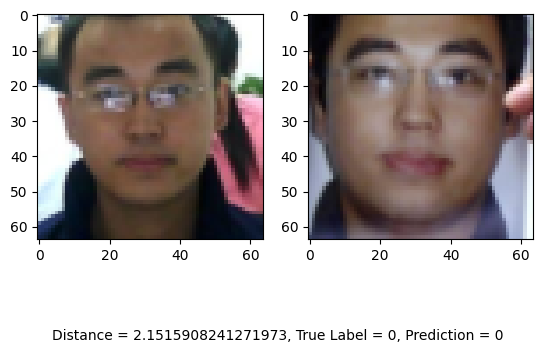

In [20]:
i = random.randint(0, n)
show_res(model1, img1[i], img2[i], labs[i], threshold1)

Distance = 0.15541526675224304 True Label = 1 Preditcion = 1


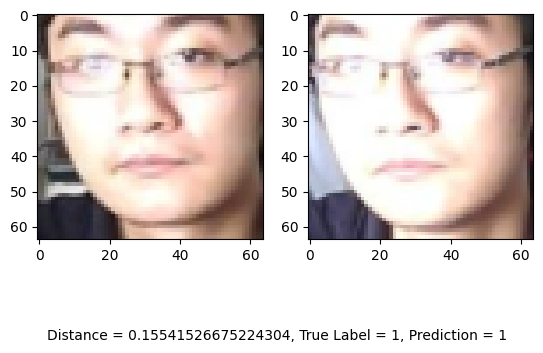

In [21]:
i = random.randint(0, n)
show_res(model1, img1[i], img2[i], labs[i], threshold1)

Distance = 0.14637035131454468 True Label = 1 Preditcion = 1


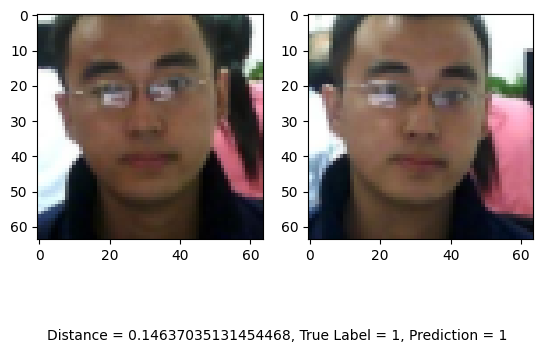

In [22]:
i = random.randint(0, n)
show_res(model1, img1[i], img2[i], labs[i], threshold1)

Distance = 0.12382174283266068 True Label = 1 Preditcion = 1


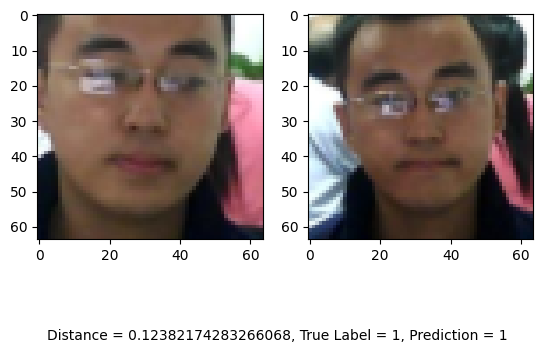

In [23]:
i = random.randint(0, n)
show_res(model1, img1[i], img2[i], labs[i], threshold1)

Distance = 2.2074034214019775 True Label = 0 Preditcion = 0


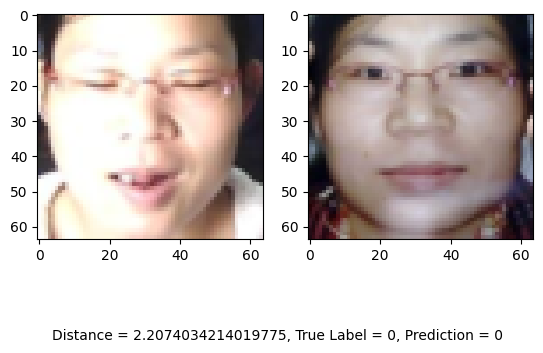

In [24]:
i = random.randint(0, n)
show_res(model1, img1[i], img2[i], labs[i], threshold1)